In [1]:
from numpy import array
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib as mp
import time
import seaborn as sb
import matplotlib as mpl 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.externals import joblib

/cs/home/ybk1/Documents/Modules/CS5014/Classification/env/lib64/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Sections of the report 

-	Abstract
-	Introduction
-	Methods
    -	Cleaning the data and creating new input features
    - Analysing and visualising the data
    - Preparing the inputs and choosing suitable features
    - Selecting and training a model
- Training the model
- K fold cross validation
- Fine-tuning the models
-	Evaluation
-	Discussion 
-	Conclusion


## 1. Introduction

This study will be taking a data driven approach towards classifying images of seals. The dataset used 

## 2. Method

### 2.1 Loading and cleaning the data set


In [2]:
# Load the datasets

#binary datasets
X_train_binary = pd.read_csv('/data/CS5014-P2/binary/X_train.csv', header=None)
Y_train_binary = pd.read_csv('/data/CS5014-P2/binary/Y_train.csv', header=None)
X_test_binary = pd.read_csv('/data/CS5014-P2/binary/X_test.csv', header=None)

#multi datasets
X_train_multi = pd.read_csv('/data/CS5014-P2/multi/X_train.csv', header=None)
Y_train_multi = pd.read_csv('/data/CS5014-P2/multi/Y_train.csv', header=None)
X_test_multi = pd.read_csv('/data/CS5014-P2/multi/X_test.csv', header=None)

###  Cleaning the dataset

a) **Check for Null-values and inconsistent data types:** Upon looking at that dataset, we can see that each column has an equal amount of non-null values, indicating that there are **no instances** of missing data. Moreover, all the data types are float64, indicating a consistency in data format

In [3]:
# Check for Null-values
print(X_train_multi.info(null_counts=True))
print(X_train_binary.info(null_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62210 entries, 0 to 62209
Columns: 964 entries, 0 to 963
dtypes: float64(964)
memory usage: 457.5 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62210 entries, 0 to 62209
Columns: 964 entries, 0 to 963
dtypes: float64(964)
memory usage: 457.5 MB
None


b) **Check for duplicate values**: No duplicate values were found

In [4]:
# remove duplicate rows
datasets = [X_train_binary,Y_train_binary, X_test_binary, X_train_multi, X_train_multi, X_test_multi]

for data in datasets:
    duplicate_rows = data[data.duplicated()]
    print(len(duplicate_rows))

0
62208
0
0
0
0


No null values, no duplicate and all the data types were for the dtype float64. Nothing needed to change so will proceed to visualising the dataset


### 2.1.2 Create a preliminary test set

Despite there being a already a test set in place, a preliminary test set was created, to evaluate the performance of the model and to see how well the model could
generalise on unseen data. The training data was split with an 80/20 split in stratified fashion, in order to keep the proportion of the classes as the dataset
was already heavily imbalanced.

In [5]:
# Splits the training set
X_train_B, X_pre_test_B, y_train_B, y_pre_test_B = train_test_split(X_train_binary, Y_train_binary, test_size=0.20, stratify=Y_train_binary, random_state=27)
X_train_M, X_pre_test_M, y_train_M, y_pre_test_M = train_test_split(X_train_multi, Y_train_multi, test_size=0.20, stratify=Y_train_multi, random_state=27)

# Resets the indexes
X_train_B = X_train_B.reset_index(drop=True)
X_pre_test_B = X_pre_test_B.reset_index(drop=True)
y_train_B = y_train_B.reset_index(drop=True)
y_pre_test_B = y_pre_test_B.reset_index(drop=True)

X_train_M = X_train_M.reset_index(drop=True)
X_pre_test_M = X_pre_test_M.reset_index(drop=True)
y_train_M = y_train_M.reset_index(drop=True)
y_pre_test_M = y_pre_test_M.reset_index(drop=True)

### 2.2 Analysing and Visualising the dataset

#### 2.2.1 Visualising the images


The dataset has 62210 images, with around 964 features. To visualise the images, I sliced the first
900 columns to get the Histogram of Orientated Gradient (HOG) features and picked an image from each class found in the Y_train datasets

Figure 1 below, showes the images taken from the binary dataset, where classes are either background and seal. 
Figure 2, shows images from the multi dataset, where images are background, dead pup, whitecoat, moulted pup, juvenile

In [6]:
bin_classes = ['background','seal']
mult_classes = ['background','dead pup', 'whitecoat', 'moulted pup', 'juvenile']

def get_rows_and_titles(classes, dataset, num):
    """
    Method for getting the row numbers and titles for each class
    """
    rows = np.array([])
    titles = np.array([])
    for i in classes:
        filt = dataset.iloc[:,0] == i
        filtered_data = dataset[filt].head(num)
        rows = np.concatenate([rows, filtered_data.index.values])
        titles = np.concatenate([titles, array(filtered_data.iloc[:,0])])
    
    return rows.astype(int), titles  
      
        
bin_rows, bin_titles = get_rows_and_titles(bin_classes, y_train_B,1)
mult_rows, mult_titles = get_rows_and_titles(mult_classes, y_train_M,1)

bin_titles

array(['background', 'seal'], dtype=object)

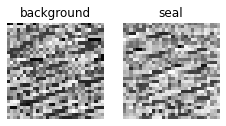

In [7]:
# classes in the  binary dataset
no_rows_bin  = 2
no_rows_mult = 2
def print_images(no_rows,row_numbers, titles, dataset, width, height):
    """
    Converts the HoG features provided into a 30 x 30 image
    """
    fig = plt.figure(figsize=(width, height))
    for i in range(1, len(row_numbers) +1): 
        output = array(dataset.iloc[row_numbers[i-1], :900])
        output_image = output.reshape(30, 30)
        fig.add_subplot(no_rows, 5, i)
        plt.imshow(output_image, cmap = mpl.cm.binary, interpolation="nearest")
        plt.title(titles[i-1])
        plt.axis("off")
        
    plt.show()

print_images(no_rows_bin, bin_rows, bin_titles, X_train_B,10,5)

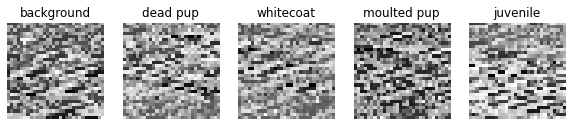

In [8]:
print_images(no_rows_mult, mult_rows, mult_titles, X_train_M,10,5)

In both datasets, we can see that the "backgound" classes appears to have the least amount of dark pixelation compared to the others. 
In the mult-classification dataset, the whitecoat image appears to be the most distinct

#### 2.2.2 Visualising the class distribution in the data

To understand the distribution of the classes in both the binary and multi datasets, I visualised the frequency distribution of the classes


In [9]:
# prepare data for visualisation
bin_freq= y_train_B.iloc[:,0].value_counts()
mult_freq= y_train_M.iloc[:,0].value_counts()

mult_classes = array(mult_freq.keys())
mult_data = mult_freq.values
bin_classes = array(bin_freq.keys())
bin_data = bin_freq.values

classes = [mult_classes, bin_classes]
mult_and_bin_freq = [mult_data, bin_data]
titles = ["Multi","Binary"]


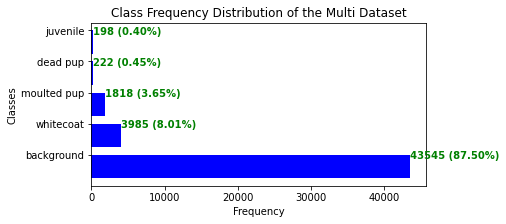

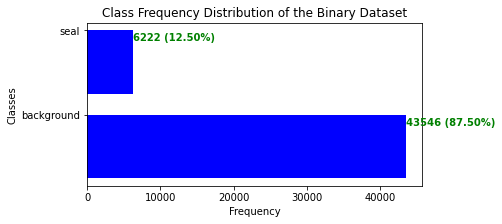

In [10]:
# X_train_multi.iloc[:,0].value_counts().plot(kind='barh') #horizontal bar plot

def get_pct(array, value):
    """
    Gets the percentage of a value in proportion to the sum of an array
    return: pct_string
    """
    pct = value/array.sum()
    pct_string =  " ({:.2%})".format(pct)
    return pct_string
#
def plot_class_dist(data,classes, title):
    """
    Plots a 2-D plot, showing the relationship between classes and frequency
    """
    fig, ax = plt.subplots(figsize=(6, 3))    
    width = 0.75 # the width of the bars 
    ind = np.arange(len(data))  # the x locations for the groups
    ax.barh(ind, data, width, color="blue")
    ax.set_yticks(ind+width/2)
    ax.set_yticklabels(classes, minor=False)
    plt.title("Class Frequency Distribution of the " + title +  " Dataset")
    plt.xlabel('Frequency')
    plt.ylabel('Classes')
    for i, v in enumerate(data):
        ax.text(v + 3, i + .25, str(v) + get_pct(data,v), color='green', fontweight='bold')
    plt.show()
    
for i in range(2):
    plot_class_dist(mult_and_bin_freq[i],classes[i],titles[i])

It is evident that both datasets are heavily skewed towards the background class, accounting for 87.5% of the dataset. Given this large proportion of the background class in the dataset,
it may be no suprise that the classification algorithm is able to classify the background class very well. On the other hand, the juvenile and moulted pup classes
account for 0.40% and 0.45% respectively. Given the skewed data set it will make sense to stratify the training sets to keep a consistent distribution. 

#### 2.2.3 Visualising Variance Using PCA and t-SNE

**PCA**

PCA is a popular technique for reducing the number of dimensions in a dataset whilst retaining most information. PCA preserves variances by identifying the axis that accounts for the largest amount of variance in the training set (hands on). It then finds a 2nd axis which is orthogonal to the first one, that accounts for the largest amount of remaining variance. In higher dimensions, PCA would find a 3rd axis and then an ith axis, based on the number of dimensions in the dataset. The vector that defines each axis is called the the Priniciapal component. For visualising purposes, I reduced the dimensions down to 3 dimensions and plotted the 1st and 2nd Principal componetns against each other. (See figure 5). Using the explained 
variance ratio, I found that 35.6% of the dataset's variance lied in the first axis, 20.1% in the 2nd axis and 14% in the 3rd axis. Thus the first three components accounted for 69.7% of the entire dataset. 

https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b


We can see from Figure 3, that the data relating to the seal has the highest variance as it dominates the X axis of PCA 1. The data relating to background, appears to have a lower variance as it appears for the highest PCA values for PCA 2


**t-SNE**

original paper = http://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf
t-Distributed Stochastic Neighbor Embedding (t-SNE) is another technique for dimensionality reduction and is particularly well suited for the visualization of high-dimensional datasets. Contrary to PCA it is not a mathematical technique but a probablistic one.


Cumulative variance explained by 100 principal components: 0.7345969364806564
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.011s...
[t-SNE] Computed neighbors for 1000 samples in 0.317s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 6.191957
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.920464
[t-SNE] KL divergence after 300 iterations: 1.894783
t-SNE done! Time elapsed: 1.775820016860962 seconds
Cumulative variance explained by 100 principal components: 0.7239708350409498
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.012s...
[t-SNE] Computed neighbors for 1000 samples in 0.275s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 6.280138
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.503349
[t-SNE] KL divergence after 300 iterations: 1.942360
t-SNE done! Time elapsed: 1.430283546447754 seconds


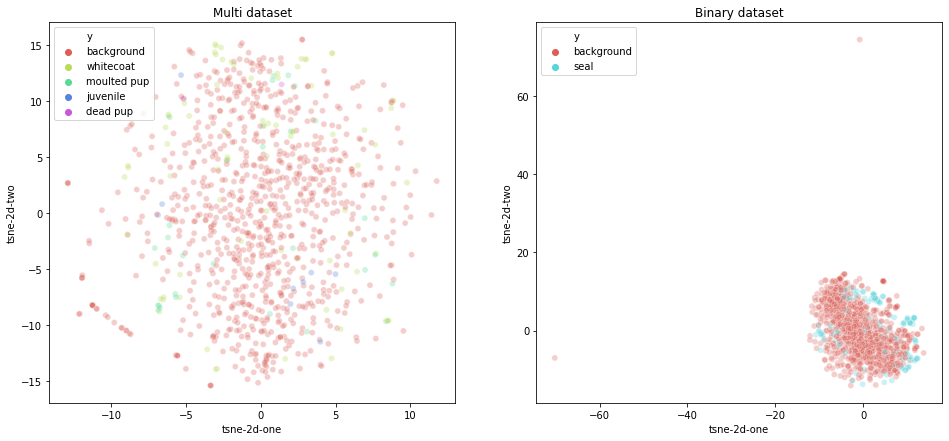

In [11]:
# scale binary dataset
std_B = StandardScaler().fit(X_train_B)
X_train_B_std = std_B.transform(X_train_B)

# scale multi dataset
std_M = StandardScaler().fit(X_train_M)
X_train_M_std = std_M.transform(X_train_M)

# data lists
X_train_std_list = [X_train_M_std, X_train_B_std]
Y_train_list = [y_train_M,y_train_B]
no_colors = [5,2]
   
def plot_pca(X_train_list,y_train_list, no_colors, titles):
    """
    Plots a 2-Dimensional plot of the PCA components 
    """
    plt.figure(figsize=(16,7))
    for j in range(2):
        
        # prepare data for visualisation
        y = array(y_train_list[j].iloc[:,0])
        feat_cols = ['pixel'+str(i) for i in range(X_train_B.shape[1])]
        df = pd.DataFrame(array(X_train_list[j]), columns=feat_cols)
        df['y'] = y
        df['label'] = df['y'].apply(lambda i: str(i))

        X, y = None, None

        # add random permuation for reproducability of the results
        np.random.seed(42)
        rndperm = np.random.permutation(X_train_list[j].shape[0])

        # Set PCA components
        N = 60000
        df_subset = df.loc[rndperm[:N],:].copy()
        data_subset = df_subset[feat_cols].values
        pca = PCA(n_components=3)
        pca_result = pca.fit_transform(data_subset)
        df_subset['pca-one'] = pca_result[:,0]
        df_subset['pca-two'] = pca_result[:,1] 
        df_subset['pca-three'] = pca_result[:,2]
        print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
        
        # plot PCA components 
        
        ax1 = plt.subplot(1, 2, j+1)
        sb.scatterplot(
            x="pca-one", y="pca-two",
            hue="y",
            palette=sb.color_palette("hls", no_colors[j]),
            data=df_subset,
            legend="full",
            alpha=0.3,
            ax=ax1
        )
        ax1.set_title(titles[j] + " dataset")

def plot_tsne(X_train_list,y_train_list, no_colors, titles):
    """
    Plots a 2-Dimensional plot of the t-SNE components
    """
    plt.figure(figsize=(16,7))
    for j in range(2):
        
        # prepare data for visualisation
        y = array(y_train_list[j].iloc[:,0])
        feat_cols = ['pixel'+str(i) for i in range(X_train_B.shape[1])]
        df = pd.DataFrame(array(X_train_list[j]), columns=feat_cols)
        df['y'] = y
        df['label'] = df['y'].apply(lambda i: str(i))

        X, y = None, None

        # add randome permuation for reproducability of the results
        np.random.seed(42)
        rndperm = np.random.permutation(X_train_list[j].shape[0])

        # Set PCA components
        N = 1000
        df_subset = df.loc[rndperm[:N],:].copy()
        data_subset = df_subset[feat_cols].values
        pca = PCA(n_components=100)
        pca_result = pca.fit_transform(data_subset)
        print('Cumulative variance explained by 100 principal components: {}'.format(np.sum(pca.explained_variance_ratio_)))
        
        #Set TSNE components
        time_start = time.time()
        tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
        tsne_results = tsne.fit_transform(pca_result)
        print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
        df_subset['tsne-2d-one'] = tsne_results[:,0]
        df_subset['tsne-2d-two'] = tsne_results[:,1]

        # plot PCA components 
        
        ax1 = plt.subplot(1, 2, j+1)
        sb.scatterplot(
            x="tsne-2d-one", y="tsne-2d-two",
            hue="y",
            palette=sb.color_palette("hls", no_colors[j]),
            data=df_subset,
            legend="full",
            alpha=0.3,
            ax=ax1
        )
        ax1.set_title(titles[j] + " dataset")
    
    
    
# for i in range (2):
plot_tsne(X_train_std_list, Y_train_list, no_colors, titles)

### 2.3 Preparing the inputs and choosing suitable features (TODO)

- Discuss about the features and their properties i.e HOG features, their importance and everything else
- Understand the correlation of the features with one another


To have a better understanding of how the features related with one .

The dataset is imbalanced - https://www.aaai.org/Papers/Workshops/2000/WS-00-05/WS00-05-001.pdf

#### 2.3.1 Choosing Suitable features 

Since the data is split up into three different groups, I decided to test different feature subsets using a baseline logistic regression, in order to choose a 
specific subset for further training and optimising. 

In [12]:
# Binary dataset feature subsets
X_train_B_HoG = X_train_B.iloc[:, :900]
X_train_B_normal = X_train_B.iloc[:, :916]
X_train_B_colour = X_train_B.iloc[:, 916:964]
X_train_B_colour = pd.concat([X_train_B_HoG, X_train_B_colour], axis=1)
X_train_B_list = {'X_train_B': X_train_B, 'X_train_B_HoG': X_train_B_HoG,
                 'X_train_B_normal': X_train_B_normal, 'X_train_B_colour': X_train_B_colour}

# Binary dataset feature subsets
X_train_M_HoG = X_train_M.iloc[:, :900]
X_train_M_normal = X_train_M.iloc[:,:916]
X_train_M_colour = X_train_M.iloc[:, 916:964]
X_train_M_colour = pd.concat([X_train_M_HoG, X_train_M_colour], axis=1)
X_train_M_list = {'X_train_M': X_train_M, 'X_train_M_HoG': X_train_B_HoG,
                 'X_train_M_normal': X_train_M_normal, 'X_train_M_colour': X_train_M_colour}



X_train_M_normal

,0,1,2,3,4,5,6,7,8,9,...,906,907,908,909,910,911,912,913,914,915
0,0.232835,0.232835,0.232835,0.205742,0.152375,0.060610,0.101681,0.125918,0.150612,0.220677,...,1.287121,0.895055,3.959312,-1.227711,0.530159,2.433729,0.628207,-0.357678,-0.596715,-1.196730
1,0.232690,0.112012,0.042675,0.232690,0.232690,0.113497,0.146875,0.149322,0.124243,0.232276,...,-0.961584,3.124169,2.382574,0.323487,-1.132590,-0.875752,1.389034,0.899067,1.380139,0.127554
2,0.198607,0.084401,0.161244,0.241175,0.241175,0.095981,0.059718,0.055162,0.099060,0.241175,...,0.586730,-0.480540,0.315535,3.401514,-4.556950,2.261027,1.146323,0.136527,2.344597,1.613794
3,0.212776,0.175364,0.188769,0.074026,0.149371,0.212776,0.187895,0.177190,0.212776,0.184851,...,-0.060430,0.927877,1.723963,-0.046804,-2.904966,-0.022417,-2.005191,-0.085171,-0.959829,3.473038
4,0.150391,0.353580,0.353580,0.018248,0.131273,0.000000,0.000000,0.000000,0.000000,0.134443,...,0.755393,-1.394441,-2.045749,-0.730268,-0.927314,2.777916,-2.527494,3.345793,0.831892,1.989985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49763,0.226119,0.108680,0.042798,0.134045,0.244547,0.234759,0.191450,0.149591,0.073138,0.203239,...,2.013086,2.115969,-0.226334,-0.611041,-0.123493,1.102664,1.779493,2.380912,1.451032,-1.953461
49764,0.113311,0.021632,0.021278,0.057420,0.058933,0.079382,0.079156,0.125918,0.080871,0.138697,...,0.527627,2.547303,1.213571,0.249646,1.127265,0.519841,-1.645113,6.006616,0.952082,2.140397
49765,0.159572,0.116054,0.126144,0.109859,0.259162,0.064583,0.185037,0.123467,0.123134,0.259162,...,1.312197,-0.966944,-1.812192,1.287150,0.265419,1.350658,0.365364,0.259938,-0.037431,1.115319
49766,0.222725,0.082913,0.147927,0.077990,0.217134,0.199568,0.222725,0.222725,0.222725,0.222725,...,2.530831,5.379321,0.589726,0.591629,-0.459764,1.521996,-1.697730,3.098863,-0.631125,-2.395888


In [13]:
def get_corr(X_train,y_train):
    """
    Gets the correlation of the features between the 
    """
    # concatenate our training data back together
    X_train = pd.DataFrame(X_train)
    y_train = y_train.rename(columns={0: "classes"})
    X = pd.concat([X_train, y_train], axis=1)
    convert_classes = {"classes":     {"background": 0, "seal": 1}}
    X.replace(convert_classes, inplace=True)
    corr = X.corr()
    top_feat = corr['classes'].sort_values(ascending = False).head(10)
    bot_feat = corr['classes'].sort_values(ascending = True).head(10)
    return top_feat,bot_feat


#### 2.3.2 Scaling

The paper mentioned that scaling was important for getting good results as normalisation helps to remove the effect of local lights differences. 

http://www.geocities.ws/talh_davidc/#cst_extract

In [14]:
# scale binary dataset - both training and test sets
scaler_B = StandardScaler()
X_train_B_HoG = scaler_B.fit_transform(X_train_B_HoG)
X_pre_test_B_HoG = pd.DataFrame(scaler_B.transform(X_pre_test_B.iloc[:, :900]))
X_test_binary_HoG = pd.DataFrame(scaler_B.transform(X_test_binary.iloc[:, :900]))

# scale multi dataset - both training and test sets
scaler_M = StandardScaler()
X_train_M_HoG = pd.DataFrame(scaler_M.fit_transform(X_train_M_HoG))
X_pre_test_M_HoG = pd.DataFrame(scaler_M.transform(X_pre_test_M.iloc[:, :900]))
X_test_multi_HoG = pd.DataFrame(scaler_M.transform(X_test_multi.iloc[:, :900]))

#### 2.3.3 Dimensionality reduction with PCA

Earlier dimensionality reduction was used for visualisation, now it will be used for training and evaluation purposes. As opposed to only used 2 principal components
, the aim would be to find the optimal amount of principal components so as to reduce the dimensions while having a high amount of variance in the data > 95%


In [15]:
pca = PCA()
pca.fit(X_train_B_HoG)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.99) + 1


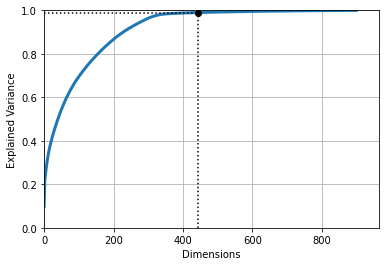

In [16]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 964, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.99], "k:")
plt.plot([0, d], [0.99, 0.99], "k:")
plt.plot(d, 0.99, "ko")
plt.grid(True)
plt.savefig('figures/explained variance vs dimension.png')
plt.show()

In [17]:
# use minimum number of dimensions required to preserve 99% of the variance
pca = PCA(n_components=444)
X_train_B_PCA = pca.fit_transform(X_train_B_HoG)

#### 2.3.4 Resampling

Study on why PCA should be done before - https://arxiv.org/ftp/arxiv/papers/1403/1403.1949.pdf

To address the issue of having an unbalanced dataset, this study investigated resampling techniques such as oversampling and undersampling

- Oversampling: Oversampling can be defined as adding more copies of the minority class. Oversampling can be a good choice when you don’t have a ton of data to work with.
- Undersampling: is a method of reducing copies of a majority class

In [18]:
def oversample_bin(X_train, y_train):
    """
    Oversamples the minority class of a binary dataset and
    return: X_train_ov, y_train_ov
    """
    # concatenate our training data back together
    X_train = pd.DataFrame(X_train)
    y_train = y_train.rename(columns={0: "classes"})
    X = pd.concat([X_train, y_train], axis=1)

    # separate minority and majority classes
    not_seal_bool = X['classes']=='background'
    not_seal = X[not_seal_bool]
    seal_bool = X['classes']=='seal'
    seal = X[seal_bool]

    # upsample minority
    seal_upsampled = resample(seal,
                              replace=True, # sample with replacement
                              n_samples=len(not_seal), # match number in majority class
                              random_state=27) # reproducible results

    # combine majority and upsampled minority
    upsampled = pd.concat([not_seal, seal_upsampled])
    y_train_ov = upsampled['classes']
    X_train_ov = upsampled.drop(columns='classes', axis=1)
    oversampled_data = [X_train_ov, y_train_ov]
    return oversampled_data
   
def undersample_bin(X_train, y_train):
    """
    Undersamples the minority class of a binary dataset and
    return: X_train_ov, y_train_ov
    """
    # concatenate our training data back together
    X_train = pd.DataFrame(X_train)
    y_train = y_train.rename(columns={0: "classes"})
    X = pd.concat([X_train, y_train], axis=1)

    # separate minority and majority classes
    not_seal_bool = X['classes']=='background'
    not_seal = X[not_seal_bool]
    seal_bool = X['classes']=='seal'
    seal = X[seal_bool]

    # downsample majority
    not_seal_downsampled = resample(not_seal,
                                    replace = False, # sample without replacement
                                    n_samples = len(seal), # match minority n
                                    random_state = 27) # reproducible results

    # combine minority and downsampled majority
    downsampled = pd.concat([not_seal_downsampled, seal])
    y_train_down = downsampled['classes']
    X_train_down = downsampled.drop(columns='classes', axis=1)
    undersampled_data = [X_train_down, y_train_down]
    return undersampled_data


### Generating synthetic data

Paper on the combination of PCA and SMOTE: https://arxiv.org/ftp/arxiv/papers/1403/1403.1949.pdf

A technique similar to upsampling is to create synthetic samples. Here we will use imblearn’s SMOTE or Synthetic Minority Oversampling Technique. 
SMOTE uses a nearest neighbors algorithm to generate new and synthetic data we can use for training our model.



In [19]:
# SMOTE

def smote_bin(X_train, y_train):
    sm = SMOTE(random_state=27)
    X_train, y_train = sm.fit_sample(X_train, y_train)
    smote_data = [X_train, y_train]
    return smote_data


In [20]:
resampled_data = {'SMOTE':smote_bin(X_train_B_HoG,y_train_B), 
                   'Undersampled':undersample_bin(X_train_B_HoG, y_train_B),
                  'Oversampled': oversample_bin(X_train_B_HoG, y_train_B),
                    'Original': [X_train_B_HoG,y_train_B]}

resampled_PCA =  {'SMOTE_PCA':smote_bin(X_train_B_PCA,y_train_B), 
                   'Undersampled_PCA':undersample_bin(X_train_B_PCA, y_train_B),
                  'Oversampled_PCA': oversample_bin(X_train_B_PCA, y_train_B),
                    'Original_PCA': [X_train_B_PCA,y_train_B]}

## 2.4 Training The Model 

### 2.4.1 Models used 

- Logistic regression
- SVM
- MLP
- Random Forrest - imbalanced dataset with RF https://ieeexplore.ieee.org/abstract/document/4410397

### 2.4.2 Out of the box classifier

The first models that I will use are logistic regression and SVM

In [23]:
#fit the logistic regression

def choose_predict(classifier, X,Y,is_cross_val):
    if is_cross_val == True:
        return cross_val_predict(classifier, X, Y, cv=3)
    else:
        return classifier.predict(X)

def choose_clf(clf):
    clf_dict= {
        'LogReg':LogisticRegression(random_state=0),
        'RF': RandomForestClassifier(max_depth=10, n_estimators=10, random_state=0, n_jobs=-1),
        'SVC': SVC(kernel='poly',degree=2, max_iter=10000, verbose=True),
    }
    return clf_dict[clf]

def get_results(Y,Y_pred, dataset_type):
    results = {}
    if dataset_type == 'binary':
        results["Accuracy"] = accuracy_score(Y, Y_pred)
        results["Precision"] = precision_score(Y, Y_pred, pos_label='seal')
        results["Recall"] = recall_score(Y, Y_pred, pos_label='seal')
        results["F1 Score"] = f1_score(Y, Y_pred, pos_label='seal')
        return results
    else:
        results["Accuracy"] = accuracy_score(Y, Y_pred)
        results["Precision"] = precision_score(Y, Y_pred, average='micro')
        results["Recall"] = recall_score(Y, Y_pred, average='micro')
        results["F1 Score"] = f1_score(Y, Y_pred, average='micro')
        return results
    

def run_clf(X, Y, dataset_name, dataset_type, is_cross_val,clf):
    """
    Runs the Random Forest classifier using either cross validation or a 1 off prediction. Trains the model 
    and scores it on the given dataset, providing results for accuracy, precision, recall, f1 score
    and a confusion matrix
    :return: rf, results
    """""
    Y = Y.values.ravel()
    results = {}
    model = choose_clf(clf).fit(X, Y)
    Y_pred = choose_predict(model, X,Y, is_cross_val)
    cm = confusion_matrix(Y, Y_pred)
    results = get_results(Y,Y_pred, dataset_type)
    print("{1} Performance Results on the {0} dataset: \n".format(dataset_name,clf) + str(results))
    print(cm) 
    return model, results

for key in X_train_M_list:
    run_clf(X_train_M_list[key], y_train_M,key,"multi",False,'RF')

time_start = time.time()

# for key in resampled_PCA:
#     run_svc(resampled_PCA[key][0],resampled_PCA[key][1],key)
#     print('Prediction done! Time elapsed: {} seconds'.format(time.time()-time_start))

# for key in resampled_data:
#     run_svc(resampled_data[key][0],resampled_data[key][1],key)
#     print('Prediction done! Time elapsed: {} seconds'.format(time.time()-time_start))

RF Performance Results on the X_train_M dataset: 
{'Accuracy': 0.9471547982639447, 'Precision': 0.9471547982639447, 'Recall': 0.9471547982639447, 'F1 Score': 0.9471547982639447}
[[43533     0     0     0    12]
 [  143    16     0     2    61]
 [  141     0    34     2    21]
 [  948     0     0   499   371]
 [  927     0     0     2  3056]]
RF Performance Results on the X_train_M_HoG dataset: 
{'Accuracy': 0.8751004661629963, 'Precision': 0.8751004661629963, 'Recall': 0.8751004661629963, 'F1 Score': 0.8751004661629963}
[[43545     0     0     0     0]
 [  222     0     0     0     0]
 [  198     0     0     0     0]
 [ 1817     0     0     1     0]
 [ 3979     0     0     0     6]]
RF Performance Results on the X_train_M_normal dataset: 
{'Accuracy': 0.9455674328886031, 'Precision': 0.9455674328886031, 'Recall': 0.9455674328886031, 'F1 Score': 0.9455674328886031}
[[43528     0     0     0    17]
 [  131     5     0     3    83]
 [  147     0    22     5    24]
 [  892     1     0   42